# TWITTER SENTIMENT ANALYSIS

## Data description

The input data size for the project will be a 1.6 million tweet dataset downloaded from Kaggle (about 233MB)The input data structure is a csv of the following form
"label",
 "ID", 
 "DateTime", 
 "Source", 
 "Account","Post"
 Column 1 – the polarity of the tweet (enum, int)
 Column 2– the id of the tweet (alphanumeric)
 Column 3 – the date of the tweet (UTC)
 Column 4 – the query which was used on Twitter (NO_QUERY if no query)  Column 5 – the user that tweeted (alphanumeric user id)
 Column 6 – the text of the tweet
 The input is classification using the following terminology on the Column 1 (label)0 – negative sentiment4 – positive sentimentThis is the column that is predicted in this project

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

from mlxtend.plotting import plot_decision_regions

from itertools import cycle
from math import log
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
!pip install lightgbm

In [145]:
!pip install xgboost

In [146]:
!pip install catboost

In [147]:
#Import data
df = pd.read_csv('/content/drive/MyDrive/minProject/203_course_project/training.1600000.processed.noemoticon.csv', header=None,encoding='latin-1',usecols=[0,5],names=['sentiment','tweet'])

In [ ]:
print(df.shape)


(1600000, 2)


In [ ]:
df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   tweet      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
df.describe()

,sentiment
count,1.600000e+06
mean,2.000000e+00
std,2.000001e+00
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,4.000000e+00


# Test train split

In [212]:
from sklearn.model_selection import train_test_split 
dfsplit = df#.fillna(value=9999)
df_train_strat, df_test_strat = train_test_split(dfsplit, test_size=0.1, random_state=42,stratify = dfsplit["sentiment"])

(1600000, 2)
(1280000, 2)


tweet
isPlayer Has Died! Sorry                                                                                                                                               182
good morning                                                                                                                                                            97
Good morning                                                                                                                                                            91
Headache                                                                                                                                                                90
headache                                                                                                                                                                88
                                                                                                                                           

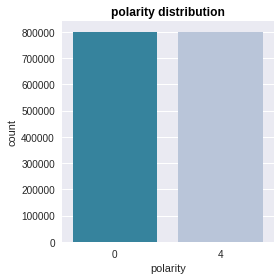

In [244]:
plt.figure(figsize = (4,4))
sns.countplot(data = df , x = df['sentiment'], palette = 'PuBuGn_r' )
plt.title('polarity distribution',weight = 'bold', color = 'black')
plt.ylabel("count")
plt.xlabel("polarity")
plt.tight_layout()

#Data Cleaning

In [177]:
nltk.download("stopwords")
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [151]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [211]:
def eliminate_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def eliminate_square_brackets(tweet):
    return re.sub('\[[^]]*\]', '', tweet)
def eliminate_url(tweet):
    return re.sub(r'http\S+', '', tweet)
def eliminate_stopwords(tweet):
    sentence = []
    for i in tweet.split():
        if i.strip().lower() not in stop:
            sentence.append(i.strip())
    return " ".join(sentence)
def eliminate_annote(tweet):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",tweet).split())
def parse_emoticons(tweet):
  for emoji in emojis.keys():
    tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
  return tweet
def retain_hashtags(s):
  #return ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",text).split())
  #([^0-9A-Za-z!?.,:@ \t])|
  s = re.sub(r":-?[()]|([^A-Za-z0-9])", lambda x: " " if x.group(1) else x.group(), s) 
  s = re.sub(r"(?<!:)(?<!:-)\(", " ", s)
  s = re.sub(r"(?<!:)(?<!:-)\)", " ", s)
  s = s.lower()
  return s
#Removing the noisy text
def denoise_text(text):
    text = eliminate_html(text)
    text = eliminate_square_brackets(text)
    text = eliminate_annote(text)
    text = parse_emoticons(text)
    text = retain_hashtags(text)
    text = eliminate_stopwords(text)
    return text

In [214]:
df_train_strat.head(10)

,sentiment,tweet
1036873,4,lol get ideas far advance even june yet need t...
287781,0,worst headache ever
333391,0,sad wont see miss already yeah perfect come ba...
1484559,4,know spell conked
562778,0,stand one knows us get used get used gone miss...
153773,0,oh yeah pray sammi shes going make past summer
644479,0,says helloo guys desktop bugged help
1377863,4,dipankar yet decided thing good place today night
131970,0,says aww last week na ng sepm
282757,0,done sophomore year two yeeaaarsss meh


In [213]:
df_train_strat['tweet']=df_train_strat['tweet'].apply(denoise_text)

In [181]:
df_train_strat.head(10)

,sentiment,tweet
1036873,4,lol get ideas far advance? even june yet! need...
287781,0,worst headache ever
333391,0,sad wont see you! miss already yeah! that's pe...
1484559,4,know spell conked
562778,0,stand one knows us get used get used gone miss...
153773,0,"oh yeah, pray sammi! shes going make past summer"
644479,0,says helloo guys desktop bugged down!!! help!!
1377863,4,dipankar yet decided thing good place today night
131970,0,says aww last week na ng sepm
282757,0,done sophomore year two yeeaaarsss meh!


##Feature Engineering 

In [215]:
tweets = df_train_strat.tweet.values
y_train = df_train_strat.sentiment.values
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(max_features=1500,ngram_range=(1,2))
x_train = tf_vectorizer.fit_transform(tweets)

##Model Building

In [227]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train, y_train)

MultinomialNB()

In [216]:
#clf = LogisticRegression()#(C = 2, max_iter = 1000, n_jobs=-1)
#clf.fit(x_train, y_train)
#model_Evaluate(LRmodel)


LogisticRegression()

In [229]:
#CBC = CatBoostClassifier()
# parameters = {'depth'         : [4,5,6,7,8,9,10],
#               'learning_rate' : [0.01,0.2,0.6,1],
#               'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
#               'l2_leaf_reg' : [0.0001,1,15]}
parameters = {'depth'         : [3],
             'learning_rate' : [0.1],
              'iterations'    : [100],
              'l2_leaf_reg' : [0.08]}
param_mnb = {
    'alpha':[0.5,1]
}
param_logistic ={
    'c':[1,2]
}
Grid_CBC = GridSearchCV(estimator=clf, 
                        param_grid = param_mnb, 
                        cv = 3, 
                        scoring=['roc_auc'],
                        refit='roc_auc')

Grid_CBC.fit(x_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)   

 Results from Grid Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=1)

 The best score across ALL searched params:
 0.8217025237540501

 The best parameters across ALL searched params:
 {'alpha': 1}


#Test Modeling

In [221]:
df_test_strat['tweet']=df_test_strat['tweet'].apply(denoise_text)

In [222]:
tweets = df_test_strat.tweet.values
y_test = df_test_strat.sentiment.values
#tf_vectorizer = TfidfVectorizer(max_features=1500)
x_test = tf_vectorizer.transform(tweets)

In [219]:
tweets

array(['denalie yes black red fav colors really wanted colors def looks awesome jared',
       'qu buy open house weekend 11am 4pm best value one bedroom lic long island city 395000 1bd',
       'fran greet air okay hahahaha thanks', ...,
       'brat following also hope atleast get also wishes getting well soon',
       'feel like decent swell since last fall hope waves myrtle beach week either least golf',
       'relaxin busy day'], dtype=object)

              precision    recall  f1-score   support

           0       0.73      0.75      0.74    160000
           4       0.74      0.72      0.73    160000

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



Text(0.5, 1.0, 'Confusion Matrix')

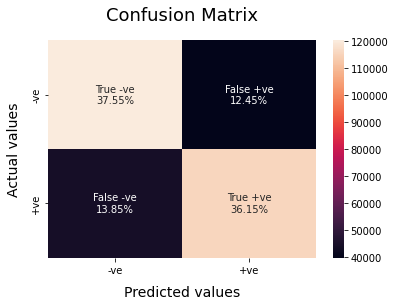

In [231]:
import seaborn as sns
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['-ve','+ve']
group_names = ['True -ve','False +ve', 'False -ve','True +ve']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#y_pred=Grid_CBC.predict(x_test)

In [232]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    f1_score,
    r2_score,
    mean_squared_error,
)
report = classification_report(y_test, y_pred)
print(report)
#print(CAT_model.get_best_score())
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)


              precision    recall  f1-score   support

           0       0.73      0.75      0.74    160000
           4       0.74      0.72      0.73    160000

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000

0.737021875


In [225]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, x_train, y_train, scoring='roc_auc',cv=5))

[0.83253947 0.83260041 0.83179897 0.83190205 0.83318952]


In [204]:
tweet=tf_vectorizer.transform(["the movie is good but songs are bad"])
y=clf.predict(tweet)
print(y)

[4]


## ROC_AUC graph

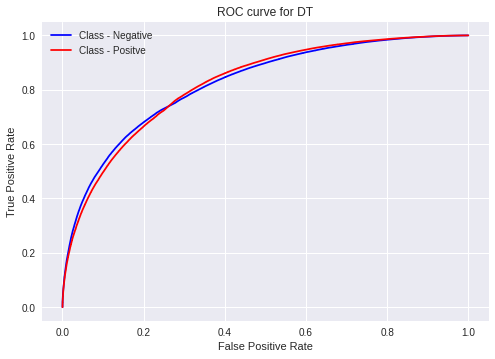

In [235]:
pred_prob1 = clf.predict_proba(x_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,0], pos_label=0)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob1[:,1], pos_label=4)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='-',color='blue', label='Class - Negative')
plt.plot(fpr2, tpr2, linestyle='-',color='red', label='Class - Positve')
plt.plot(p_fpr, p_tpr, linestyle='-', color='green')
# title
plt.title('ROC curve for DT')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive Rate')

plt.legend(loc='best')
plt.show(); 
